#### Forecast of the nosie spectrum of the cosmic birefringence reconstruction
#### - this code was used for forecasting CMB-HD white paper

In [1]:
# load modules
import numpy as np
from matplotlib.pyplot import *
import basic
import curvedsky
import plottools as pl

In [2]:
def get_obs_cls(Lcl,alpha,sigma,theta,ac2rad=np.pi/10800.,Tcmb=2.726e6):
    # Return observed cl (signal + noise cls) from delensing residual (alpha), map noise level in uK-arcmin (sigma) and beam FWHM (theta)
    # Lcl is the input lensed CMB Cls
    lcl = Lcl.copy()
    lmax = len(lcl[0,:]) - 1
    l = np.linspace(0,lmax,lmax+1)
    # delensed BB spectrum
    lcl[2,:] *= alpha
    # noise spectrum
    nl = np.zeros((4,lmax+1))
    nl[0,:] = (sigma*ac2rad/Tcmb)**2 * np.exp(l*(l+1.)*(theta*np.pi/10800.)**2/8./np.log(2.))
    nl[1,:] = 2*nl[0,:]
    nl[2,:] = 2*nl[0,:]
    return lcl + nl

In [3]:
def calc_rec_noise(olmax,rlmin,rlmax,lEE,oEE,oBB):
    # return reconstruction noise from CMB multipole range (rlmin,rlmax), lensed EE (lEE), observed EE/BB (oEE/oBB)
    # olmax: maximum output noise spectrum multipole
    return curvedsky.norm_quad.qeb('rot',olmax,rlmin,rlmax,lEE[:rlmax+1],oEE[:rlmax+1],oBB[:rlmax+1])[0]

In [4]:
def calc_sigma(Al,fsky):
    # set lmin from fsky
    lmin = np.int(180./(42000*fsky)**0.5) + 1
    olmax = len(Al) - 1
    L = np.linspace(0,olmax,olmax+1)
    claa = 2*np.pi/(L**2+L+1e-30)
    # compute 1sigma error on A_CB
    return (180./np.pi)**2 / np.sqrt(np.sum(claa[lmin:]**2/Al[lmin:]**2*(L[lmin:]+.5)))/np.sqrt(fsky)

Define parameters

In [5]:
ilmax = 5000 # maximum multipole of input spectrum
olmax = 2048 # maximum multipole of reconstruction noise spectrum
rlmin = 2 # minimum multipole of CMB for reconstruction
# set multipole arrays
l = np.linspace(0,ilmax,ilmax+1)
L = np.linspace(0,olmax,olmax+1)

Load unlensed and lensed Cls

In [6]:
# load lensed Cls
Lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,ilmax,4,bb=True)/2.72e6**2

In [7]:
# set observed Cls
ocl = {}
# AdvACT
ocl['AC'] = get_obs_cls(Lcl,1.,10.,1.) 
# LiteBIRD
ocl['LB'] = get_obs_cls(Lcl,.5,6./np.sqrt(2.),30.)
# SO LAT
ocl['LA'] = get_obs_cls(Lcl,.3,10.,1.)
# SO SAT
ocl['SA'] = get_obs_cls(Lcl,.3,3./np.sqrt(2.),17.)
# CMB-S4
ocl['S4'] = get_obs_cls(Lcl,.2,1.81/np.sqrt(2.),1.)
# CMB-HD
ocl['HD'] = get_obs_cls(Lcl,.1,.5,0.)

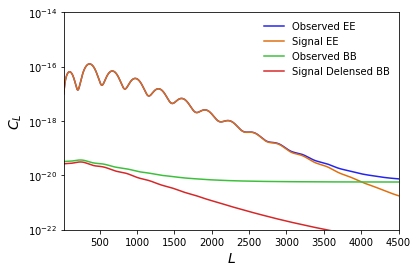

In [8]:
# plot noise spectra at high-ell EE/BB
pl.plot_1dstyle(ylog=True,xmax=4500,ymin=1e-22,ymax=1e-14)
plot(ocl['HD'][1,:],label='Observed EE')
plot(Lcl[1,:],label='Signal EE')
plot(ocl['HD'][2,:],label='Observed BB')
plot(Lcl[2,:]*.1,label='Signal Delensed BB')
legend()

In [9]:
# compute the reconstruction noise spectrum
Al = {}
for obs, rlmax in [('AC',4000),('LB',1000),('LA',4000),('SA',2000),('S4',4000),('HD',4000)]:
    Al[obs] = curvedsky.norm_quad.qeb('rot',olmax,rlmin,rlmax,Lcl[1,:rlmax+1],ocl[obs][1,:rlmax+1],ocl[obs][2,:rlmax+1])[0]

In [10]:
# compute error on the amplitude of the scale-invariant birefringence spectrum
sigma = {}
lmin, lmax = 1, 4000
for obs, fsky in [('AC',.4),('LB',.6),('LA',.4),('SA',.1),('S4',.1),('HD',.5)]:
    sigma[obs] = calc_sigma(Al[obs],fsky)
    # isotropic biref constraint in arcmin
    snr = 2*np.sqrt(np.sum((2*l[lmin:lmax+1]+1.)*fsky*Lcl[1,lmin:lmax+1]**2/(ocl[obs][1,lmin:lmax+1]*ocl[obs][2,lmin:lmax+1])))
    print('Isotropic Biref Angle Constraint from '+obs,(10800./np.pi)/snr)

Isotropic Biref Angle Constraint from AC 0.5447733776383165
Isotropic Biref Angle Constraint from LB 0.756190665155173
Isotropic Biref Angle Constraint from LA 0.533278204968647
Isotropic Biref Angle Constraint from SA 0.5598676083296941
Isotropic Biref Angle Constraint from S4 0.1612076584658465
Isotropic Biref Angle Constraint from HD 0.035875887195615776


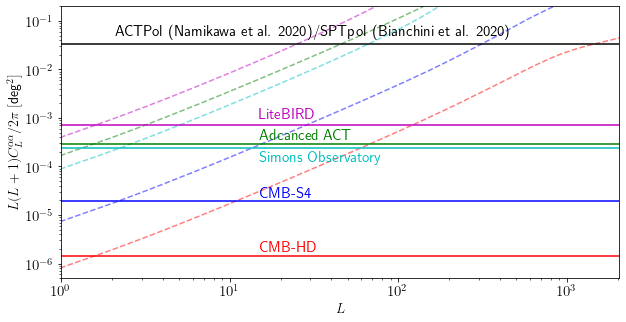

In [11]:
pl.plot_1dstyle(usetex=True,fsize=[10,5],xmin=1,xmax=olmax,xlog=True,ymin=5e-7,ymax=2e-1,ylog=True,xlab='$L$',ylab=r'$L(L+1)C_L^{\alpha\alpha}/2\pi$ $[$deg$^2]$',legend_size=15,xticks_labsize=15,yticks_labsize=15)
namesize = 15
alpha = .5
s = L*(L+1)/2./np.pi*(180./np.pi)**2/np.sqrt(L+.5)
plot(L,s*Al['AC']/np.sqrt(.4),color='g',ls='--',alpha=alpha)
plot(L,s*Al['SA']/np.sqrt(.1),color='c',ls='--',alpha=alpha)
plot(L,s*Al['LB']/np.sqrt(.6),color='m',ls='--',alpha=alpha)
plot(L,s*Al['S4']/np.sqrt(.1),color='b',ls='--',alpha=alpha)
plot(L,s*Al['HD']/np.sqrt(.5),color='r',ls='--',alpha=alpha)
axhline(1e-5*(180./np.pi)**2,color='k',ls='-')
axhline(sigma['AC'],color='g',ls='-')
axhline(sigma['SA'],color='c',ls='-')
axhline(sigma['LB'],color='m',ls='-')
axhline(sigma['S4'],color='b',ls='-',label=r'CMB-S4 (SAT)')
axhline(sigma['HD'],color='r',ls='-',label=r'CMB-HD')
figtext(.2,.8,'ACTPol (Namikawa et al. 2020)/SPTpol (Bianchini et al. 2020)',color='k',fontsize=namesize)
figtext(.4,.51,'Adcanced ACT',color='g',fontsize=namesize)
figtext(.4,.45,'Simons Observatory',color='c',fontsize=namesize)
figtext(.4,.57,'LiteBIRD',color='m',fontsize=namesize)
figtext(.4,.35,'CMB-S4',color='b',fontsize=namesize)
figtext(.4,.2,'CMB-HD',color='r',fontsize=namesize)
#legend(frameon=True,loc=1)
savefig('fig_cosmic_biref_forecast.pdf')

In [12]:
# CMB-HD
sigma['HD']

1.4307943226835768e-06